In [23]:
import os
import pandas as pd
from collections import defaultdict
import glob
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet50
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

In [2]:
# always check your version
print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

1.11.0+cu113
Using device: cuda


In [3]:
root_dir = '/root/'
local_path = 'project/data/' # store the related data files in this folder
ResultPath = root_dir + 'project/data/result/'

data_dir = root_dir + local_path
# print(data_dir)
## Define paths to the training data and targets files
data_path = data_dir + 'TrainingSet'
csv_file_path = data_dir + 'DRAC2022_ Diabetic Retinopathy Grading_Training Labels.csv'
# print(data_path)
# print(csv_file_path)


In [4]:
image_folder = data_path
all_image_paths = glob.glob(os.path.join(image_folder, '*'))
df = pd.read_csv(csv_file_path)
path_category_dict = defaultdict(list)

# print(all_image_paths)
print(df.head())

  image name  DR grade
0    001.png         0
1    002.png         0
2    003.png         0
3    004.png         0
4    005.png         0


In [5]:
for index, row in df.iterrows():
    image_name = row['image name']
    category = row['DR grade']
    full_image_path = os.path.join(image_folder, image_name) 
    if full_image_path in all_image_paths:
        path_category_dict[category].append(full_image_path)

img_paths_list = list(path_category_dict.values())
target_categories = list(path_category_dict.keys())

In [6]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.model.eval()

        # 注册钩子
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_tensor, target_category=None):
        output = self.model(input_tensor)
        if target_category is None:
            target_category = torch.argmax(output).item()

        one_hot_output = torch.FloatTensor(1, output.shape[-1]).zero_()
        one_hot_output[0][target_category] = 1
        output.backward(gradient=one_hot_output)

        target_activations = self.gradients.detach()
        weights = torch.mean(target_activations, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.gradients, dim=1).squeeze()

        cam = F.relu(cam)
        cam -= torch.min(cam)
        cam /= torch.max(cam)

        return cam


In [7]:
class OCTDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)
        return img


In [8]:
mean = 0.413
std = 0.278

transform = transforms.Compose([
    transforms.Resize((512, 512)),  # 将图像缩放到512x512
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize([mean], [std])  # 使用先前计算的均值和标准差进行标准化
])

# print(img_paths_list[0])

dataset = OCTDataset(image_paths=img_paths_list[0], transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)


In [9]:

model = resnet50(pretrained=True)
model.conv1 = nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size,
                        stride=model.conv1.stride, padding=model.conv1.padding, bias=model.conv1.bias)
model.eval()
gradcam = GradCAM(model, model.layer4[-1])


In [10]:
def generate_avg_gradcam(img_paths, target_category):
    cams = []
    for img_path in img_paths:
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        input_tensor = preprocess(img).unsqueeze(0)
        cam = gradcam(input_tensor, target_category)
        cams.append(cam)
    avg_cam = torch.mean(torch.stack(cams), dim=0)
    return avg_cam

In [12]:
# 为每种类型的多个图像生成平均的 GRAD-CAM
mean = 0.413
std = 0.278

preprocess = transforms.Compose([
    transforms.Resize((512, 512)),  # 将图像缩放到512x512
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize([mean], [std])  # 使用先前计算的均值和标准差进行标准化
])

avg_cams = []
for img_paths, target_category in zip(img_paths_list, target_categories):
    avg_cam = generate_avg_gradcam(img_paths, target_category)
    avg_cams.append(avg_cam)


/root/miniconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


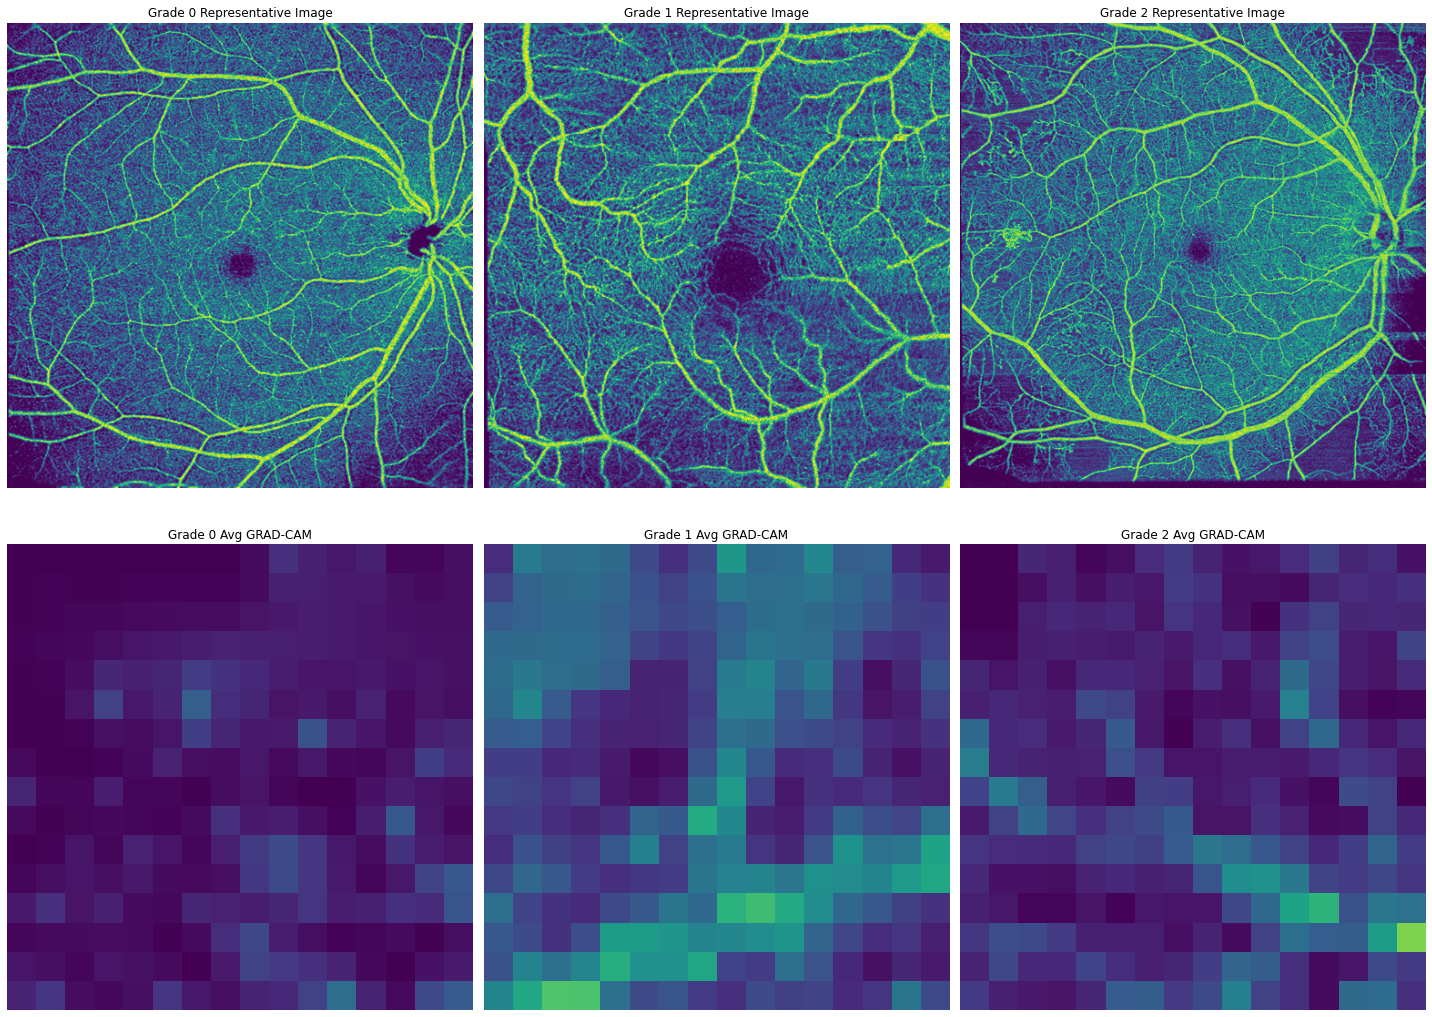

In [13]:
# 可视化和比较
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))

for i, img_paths in enumerate(img_paths_list):
    representative_img = Image.open(img_paths[0]).resize((512, 512))
    axes[0, i].imshow(representative_img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Grade {i} Representative Image')

    axes[1, i].imshow(representative_img)
    axes[1, i].imshow(avg_cams[i].detach().numpy(), cmap='jet', alpha=0.5, interpolation='bilinear')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Grade {i} Avg GRAD-CAM')

plt.tight_layout()
plt.show()

In [25]:
def overlay_heatmap_on_image(image, heatmap, alpha=0.5, colormap='jet'):
    # 确保图像是RGB格式
    if image.mode != 'RGB':
        image = image.convert('RGB')

    heatmap_normalized = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    
    # Resize heatmap to match the image size
    heatmap_resized = cv2.resize(heatmap_normalized, (image.width, image.height))
    heatmap_colored = plt.cm.get_cmap(colormap)(heatmap_resized)[:,:,:3]
    
    img_np = np.array(image)
    heatmap_np = (heatmap_colored * 255).astype(np.uint8)
    combined = (img_np * (1.0 - alpha) + heatmap_np * alpha).astype(np.uint8)
    
    return Image.fromarray(combined)


In [28]:
def overlay_heatmap_on_image(image, heatmap, alpha=0.5, colormap='jet'):
    # 确保图像是RGB格式
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # 添加一个小的epsilon以避免除以0的情况
    eps = 1e-10
    heatmap_normalized = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + eps)

    # 使用cv2调整热图大小以匹配图像大小
    heatmap_resized = cv2.resize(heatmap_normalized, (image.width, image.height))
    
    # 使用新的热图大小来获取colormap
    heatmap_colored = plt.cm.get_cmap(colormap)(heatmap_resized)[:,:,:3]
    img_np = np.array(image)
    heatmap_np = (heatmap_colored * 255).astype(np.uint8)
    combined = (img_np * (1.0 - alpha) + heatmap_np * alpha).astype(np.uint8)
    return Image.fromarray(combined)


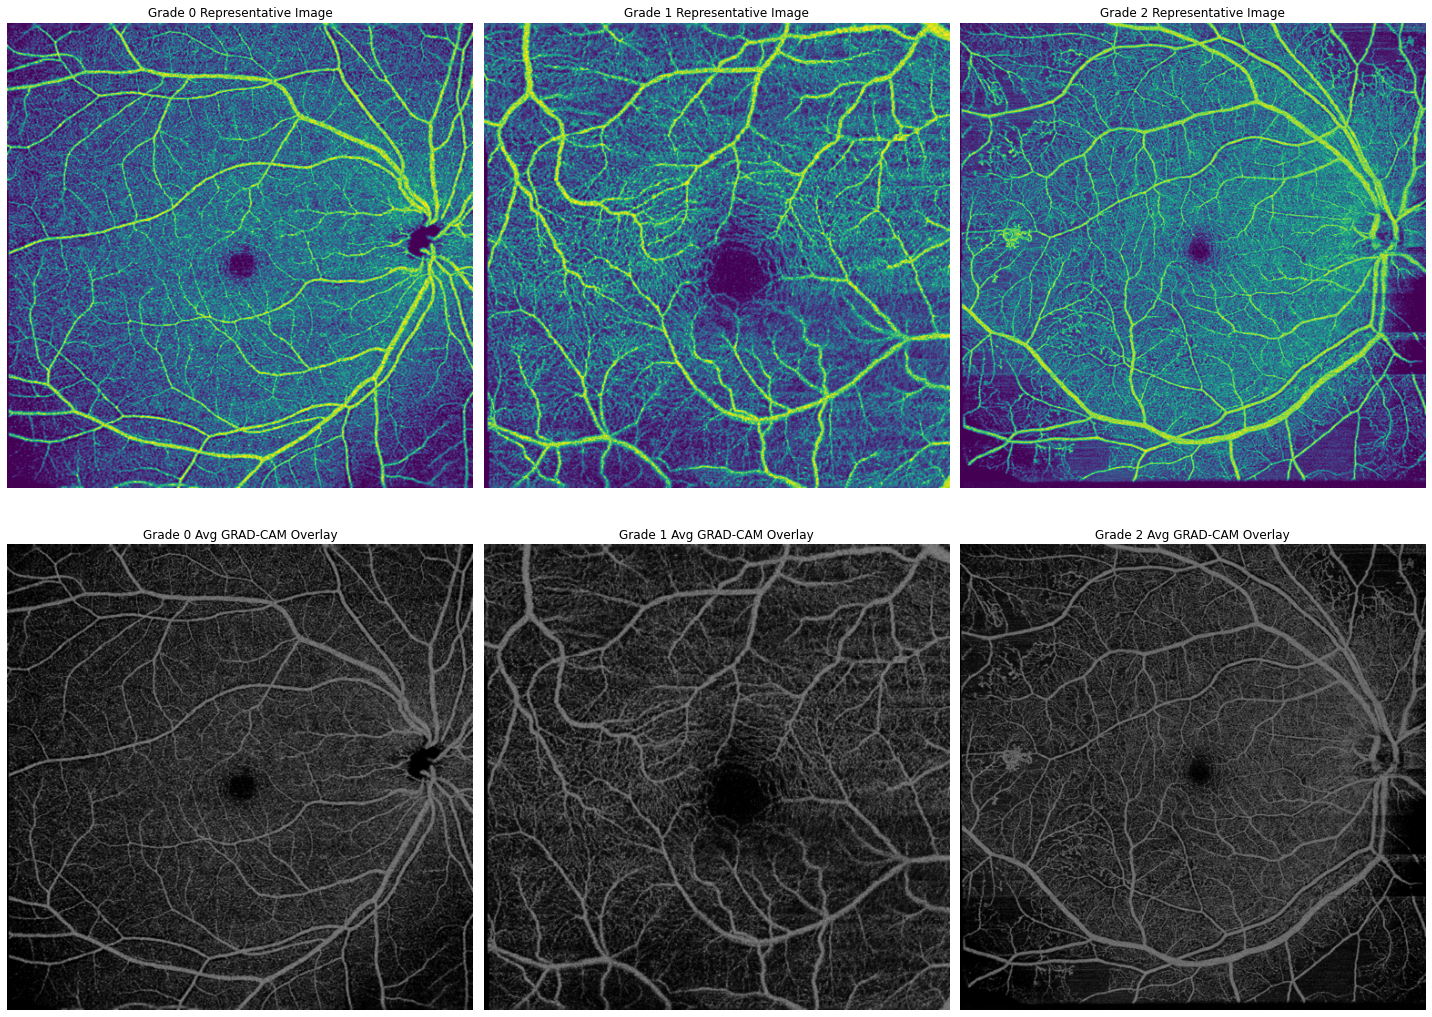

In [27]:
# 可视化和比较
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))

for i, img_paths in enumerate(img_paths_list):
    representative_img = Image.open(img_paths[0]).resize((512, 512))
    axes[0, i].imshow(representative_img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Grade {i} Representative Image')

    overlaid_image = overlay_heatmap_on_image(representative_img, avg_cams[i].detach().numpy())
    axes[1, i].imshow(overlaid_image)
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Grade {i} Avg GRAD-CAM Overlay')

plt.tight_layout()
plt.show()